In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [125]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler,  MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error
import xgboost as xgb
#import lightgbm as lgb

## 1. Global parameters

In [126]:
features_dir = '../data/01_raw/dengue_features_train.csv'
labels_dir = '../data/01_raw/dengue_labels_train.csv'
test_dir = '../data/01_raw/dengue_features_test.csv'

logged = True

test_output_dir = 'output.csv'


## 2. Building blocks functions

In [127]:
def get_train_data(features_dir, labels_dir):
    """ 
    Input:
        str to csv with train features and labels
        drop: to drop NaNs from feature columns.

    Output:
         X, y
    
    """
    features = pd.read_csv(features_dir)
    labels = pd.read_csv(labels_dir)

    data = features.merge(labels)
    
    X = data.drop(columns=['total_cases'])
    y = data.loc[:,'total_cases']
    print("Loading of training data finished.\n")
        
    return data, X, y

In [128]:
data, X, y = get_train_data(features_dir, labels_dir)
data

Loading of training data finished.



,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


In [129]:
X

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


In [180]:
def get_preprocessed_X(X, time_column='week_start_date', format='%Y-%m-%d'):
    
    # Timed features.
    X_new = X.copy()
    X_new[time_column] = pd.to_datetime(X_new[time_column], format=format)
 
    X_new['year'] =  X_new[time_column].apply(lambda x: x.year)
    X_new.loc[:,'dayofyear'] = X_new[time_column].apply(lambda x: x.dayofyear)
    X_new['weekofyear'] =  X_new[time_column].apply(lambda x: x.weekofyear)

    numerical_cols = list(X_new.select_dtypes(include=[np.number]).columns)
    categorical_cols = list(X_new.select_dtypes(include=[object]).columns)

    numerical_transformer = Pipeline(
        steps =[('imputer', SimpleImputer()),]
        )

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    return pd.DataFrame(preprocessor.fit_transform(X_new), columns=numerical_cols + ['iq', 'sj'])

In [181]:
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
y_preprocessed = log_transformer.transform(y)

In [182]:
X_preprocessed = get_preprocessed_X(X, time_column='week_start_date', format='%Y-%m-%d')

In [183]:
X_preprocessed

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,dayofyear,iq,sj
0,1990.0,18.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,120.0,0.0,1.0
1,1990.0,19.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,127.0,0.0,1.0
2,1990.0,20.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,134.0,0.0,1.0
3,1990.0,21.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,141.0,0.0,1.0
4,1990.0,22.0,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,148.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,2010.0,21.0,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,...,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,148.0,1.0,0.0
1452,2010.0,22.0,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,...,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,155.0,1.0,0.0
1453,2010.0,23.0,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,...,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,162.0,1.0,0.0
1454,2010.0,24.0,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,...,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,169.0,1.0,0.0


In [184]:
model = xgb.XGBRegressor(max_depth=5,
                     learning_rate=0.1,
                     n_estimators=100,n_jobs=-1)

In [185]:
xgb_reg = model.fit(X_preprocessed, y)
xgb_reg_log = model.fit(X_preprocessed, y_preprocessed)

In [186]:
X_test = pd.read_csv(test_dir)
X_test_preprocessed = get_preprocessed_X(X_test)

In [187]:
results = xgb_reg.predict(X_test_preprocessed)
results_log = log_transformer.inverse_transform(xgb_reg_log.predict(X_test_preprocessed))

In [188]:
results

array([1.7397509 , 1.591074  , 1.5920805 , 2.1154885 , 1.8412606 ,
       2.2287948 , 1.9331269 , 2.6351047 , 2.4287167 , 2.453741  ,
       2.5560327 , 2.7220366 , 2.9848826 , 3.3097405 , 3.9081583 ,
       3.8955204 , 3.6645906 , 3.8530583 , 4.7834115 , 4.873838  ,
       4.4098344 , 4.106569  , 4.453153  , 4.0129933 , 4.040141  ,
       3.7629502 , 3.3044684 , 3.691908  , 3.5083437 , 3.4250379 ,
       3.154438  , 2.7656934 , 2.5016062 , 2.502263  , 2.12563   ,
       2.0817714 , 2.0657394 , 2.1323476 , 2.1107645 , 1.9996464 ,
       1.6757522 , 1.8414223 , 1.5173581 , 1.5331256 , 1.2432778 ,
       1.2265648 , 0.9504261 , 1.0153868 , 0.91831523, 1.0844258 ,
       1.1139702 , 1.1650233 , 1.0291324 , 0.91395426, 1.1516103 ,
       1.0966007 , 2.0162718 , 1.7959089 , 1.6407776 , 2.2720017 ,
       2.02307   , 2.7084203 , 3.3669488 , 2.9616284 , 3.1591256 ,
       3.674605  , 3.5890052 , 3.787471  , 3.67948   , 4.332975  ,
       3.738776  , 3.2592754 , 3.1570916 , 3.7331753 , 4.06826

In [189]:
results_log

array([  4.6959243 ,   3.9090183 ,   3.9139616 ,   7.2936363 ,
         5.3044806 ,   8.288665  ,   5.911087  ,  12.944772  ,
        10.344315  ,  10.631781  ,  11.884598  ,  14.21127   ,
        18.78418   ,  26.378021  ,  48.807137  ,  48.181644  ,
        38.04015   ,  46.137005  , 118.51137   , 129.82204   ,
        81.255844  ,  59.737957  ,  84.89736   ,  54.31219   ,
        55.834362  ,  42.075317  ,  26.23406   ,  39.121323  ,
        32.392914  ,  29.723808  ,  22.439861  ,  14.890055  ,
        11.202078  ,  11.210094  ,   7.3781734 ,   7.0186605 ,
         6.8911304 ,   7.4346447 ,   7.2545495 ,   6.386444  ,
         4.3428125 ,   5.3055    ,   3.5601616 ,   3.6326342 ,
         2.4669588 ,   2.409497  ,   1.5868117 ,   1.760431  ,
         1.5050664 ,   1.957741  ,   2.0464292 ,   2.2059977 ,
         1.7986366 ,   1.4941657 ,   2.1632824 ,   1.9939711 ,
         6.510273  ,   5.0249486 ,   4.1591797 ,   8.698796  ,
         6.561504  ,  14.005552  ,  27.989939  ,  18.32

In [195]:
score = mean_absolute_error(y, xgb_reg.predict(X_preprocessed))
score

22.230779410771014

In [191]:
score_log = mean_absolute_error(y, 
                                log_transformer.inverse_transform(
                                    xgb_reg_log.predict(X_preprocessed)))
score_log

5.377550670667855

In [196]:
residual = y - xgb_reg.predict(X_preprocessed)

In [249]:
residual

0       2.255208
1       3.202665
2       2.233983
3       1.446757
4       4.159948
          ...   
1451    3.288835
1452    6.206553
1453    0.069832
1454    0.181345
1455    2.623855
Name: total_cases, Length: 1456, dtype: float64

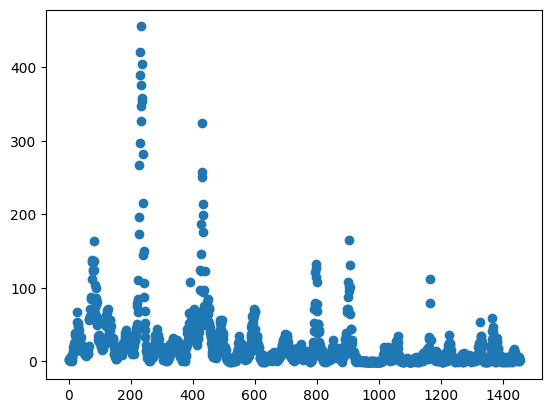

In [206]:
t_residual = np.arange(len(residual))
plt.scatter(t_residual,residual)
plt.show()

In [241]:
from statsmodels.tsa.api import ExponentialSmoothing

# choose the number of periods
seasonal_periods = 2

# create an instance of exponential smoothing and call its fit() method in one go
holt_winters = ExponentialSmoothing(
   residual,
    seasonal_periods=seasonal_periods,
    trend="add",
    seasonal="add",
    initialization_method="estimated",
#).fit(smoothing_level=0.2, smoothing_trend=0.01, smoothing_seasonal=0.15)
).fit(optimized=True)

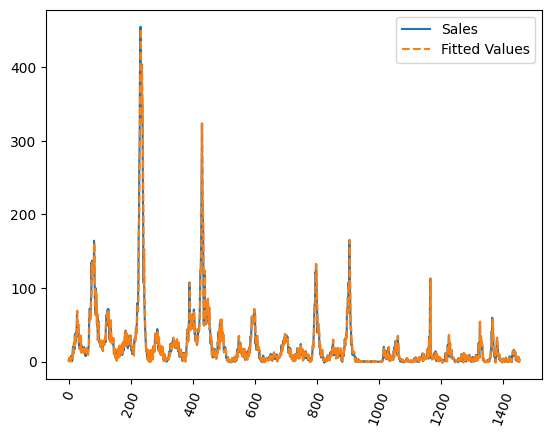

In [242]:
fig, ax = plt.subplots(1, 1)
ax.plot(t_residual, residual, label='Sales')
ax.plot(t_residual, holt_winters.fittedvalues, linestyle='--', label='Fitted Values')
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=70)
ax.legend()

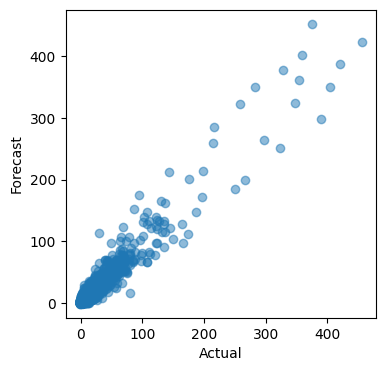

In [243]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(residual, holt_winters.fittedvalues, alpha=0.5)
#ax.plot([0, 7], [0, 7], linestyle='--')
#ax.set_xlim([0, 7])
ax.set_xlabel('Actual')
#ax.set_ylim([0, 7])
ax.set_ylabel('Forecast')
plt.show()

In [244]:

def smape(y_true, y_pred):
    actual = y_true.copy()
    forecast = y_pred.copy()
    if isinstance(actual, (pd.Series, pd.DataFrame)):
        actual = actual.values
    if isinstance(forecast, (pd.Series, pd.DataFrame)):
        forecast = forecast.values
    if isinstance(actual, np.ndarray):
        actual = actual.squeeze()
    if isinstance(forecast, np.ndarray):
        forecast = forecast.squeeze()
    
    # Ensure the arrays have the same length
    assert len(actual) == len(forecast), "Length of actual and forecast arrays should be the same"

    # Calculate SMAPE for each data point
    smape_values = 2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast))

    # Calculate the mean SMAPE value
    mean_smape = np.mean(smape_values) * 100  # Multiply by 100 to get percentage

    return mean_smape

In [245]:
smape(residual, holt_winters.fittedvalues)

62.94090119146736

In [224]:
def get_test_output(X_test, predictions, indexes = ['city', 'year', 'weekofyear'], exponentiate=False, file_dir = '../data/output.csv'):
    """
    Input:
        X_test - 
        predictions - for both cities indexed as X_test requires it and 
                        with the same number of rows as X_test. 
        indexes (List(str)) - By default the columns of X_test for the required format,
                        i.e., ['city', 'year', 'weekofyear'];
        exp (bool) - to exponentiate predictions or not;
                     
        file_dir (str) - directory with the filename of the output csv file;
                         Give an empty string if saving the output is not desired.
        
    Returns:
        output_df (pd.DataFrame) - Dataframe with formatted results
        csv file
    """

    # 1. Exponentiate the predictions if needed.
    if exponentiate:
        result = np.round(np.expm1(predictions)).astype(int)
    else:
        result = np.round(predictions).astype(int)

    # 2. Make the dictionary for the output dataframe format.
    out_dict = {}
    for index in indexes:
        out_dict[index] = X_test[index]

    out_dict['total_cases'] = result
    output_df = pd.DataFrame.from_dict(out_dict).set_index(indexes)
    
    # 3. Save predictions in a csv file ready for submission.
    if file_dir:
        print("Saved predictions in competition file format in path {} . /n".format(file_dir))
        output_df.to_csv(file_dir)
        print('\n')

    return output_df
    

In [246]:
res_forecast = holt_winters.forecast(416)

In [247]:
res_forecast

1456     1.865364
1457     2.697575
1458     1.947622
1459     2.779834
1460     2.029880
          ...    
1867    19.560506
1868    18.810552
1869    19.642764
1870    18.892811
1871    19.725022
Length: 416, dtype: float64

In [254]:
results

array([1.7397509 , 1.591074  , 1.5920805 , 2.1154885 , 1.8412606 ,
       2.2287948 , 1.9331269 , 2.6351047 , 2.4287167 , 2.453741  ,
       2.5560327 , 2.7220366 , 2.9848826 , 3.3097405 , 3.9081583 ,
       3.8955204 , 3.6645906 , 3.8530583 , 4.7834115 , 4.873838  ,
       4.4098344 , 4.106569  , 4.453153  , 4.0129933 , 4.040141  ,
       3.7629502 , 3.3044684 , 3.691908  , 3.5083437 , 3.4250379 ,
       3.154438  , 2.7656934 , 2.5016062 , 2.502263  , 2.12563   ,
       2.0817714 , 2.0657394 , 2.1323476 , 2.1107645 , 1.9996464 ,
       1.6757522 , 1.8414223 , 1.5173581 , 1.5331256 , 1.2432778 ,
       1.2265648 , 0.9504261 , 1.0153868 , 0.91831523, 1.0844258 ,
       1.1139702 , 1.1650233 , 1.0291324 , 0.91395426, 1.1516103 ,
       1.0966007 , 2.0162718 , 1.7959089 , 1.6407776 , 2.2720017 ,
       2.02307   , 2.7084203 , 3.3669488 , 2.9616284 , 3.1591256 ,
       3.674605  , 3.5890052 , 3.787471  , 3.67948   , 4.332975  ,
       3.738776  , 3.2592754 , 3.1570916 , 3.7331753 , 4.06826

In [255]:
compound_result = np.array(results)+np.array(res_forecast)

In [257]:
len(compound_result)

416

In [258]:
out_df = get_test_output(X_test, compound_result, indexes = ['city', 'year', 'weekofyear'], exponentiate=False, file_dir = 'compound_output.csv')

Saved predictions in competition file format in path compound_output.csv . /n




In [259]:
out_df

total_cases
city year weekofyear             
sj   2008 18                    4
          19                    4
          20                    4
          21                    5
          22                    4
...                           ...
iq   2013 22                   21
          23                   20
          24                   21
          25                   20
          26                   21

[416 rows x 1 columns]